# Project: Investigate a Dataset - No-show Appointments

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#questions">Questions for Analysis</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#limitations">Limitations</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 
In this project, we explore the dataset titled "No Show Appointments", which is concerned with whether patients failed to show up for scheduled medical appointments. Each row represents an individual patient, and each column represents a variable. The columns are:

**PatientId**- a unique floating point number assigned to each patient.

**AppointmentID** - a unique integer assigned to patients for the purpose of scheduling an appointment.

**Gender** - the gender of the patient. This dataset treats each patient as Male or Female.

**ScheduledDay** - the date on which the patient made the appointment.

**AppointmentDay** - the date on which the patient was supposed to show up for the appointment.

**Age** - the patient's age in years.

**Neighbourhood** - the location of the hospital in which the appointment was supposed to take place.

**Scholarship** - this tells us whether the patient was enrolled in the Brazillian welfare program Bolsa Familia.

**Hypertension** - was the patient diagnosed with hypertension? 1 means yes, 0 means no.

**Diabetes** - was the patient diagnosed with diabetes? 1 means yes, 0 means no.

**Alcoholism** - was the patient diagnosed with alcoholism? 1 means yes, 0 means no.

**Handicap** - was the patient disabled? 1 means yes, 0 means no.

**SMS_received** - did the patient receive at least one text message to remind them of the appointment? 1 means yes, 0 means no.

**No-show** - this tells us whether the patient **failed** to show up for their appointment. Yes means they failed to show, i.e. they couldn't make the appointment. No means that they did not fail to show up, i.e. they arrived for the appointment. "No-show" is equivalent to asking "Did the patient miss the appointment?". The responses are "Yes" (the patient missed the appointment), or "No" (the patient didn't miss the appointment, i.e. the appointment was a success).


<a id='questions'></a>
## Questions for Analysis
What proportion of patients overall failed to show up for their appointments? What factors strongly correlate with either tendency to show up or to miss the appointment?
The variables to examine are:
1. The gender distribution of the patients who didn't show up.
2. The number of days between the schedule date and the appointment date.
3. The age distribution of the patients who didn't show up.
4. Whether the patient was on the Scholarship programme or not.
5. How many diagnoses the patient had.
6. Whether they received an SMS.


In [1]:
# import all useful modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dtime
% matplotlib inline

In [2]:
# Upgrade pandas to use dataframe.explode() function. # causes an exception for df.head()
# !pip install --upgrade pandas==0.25.0

<a id='wrangling'></a>
## Data Wrangling

### General Properties
The first step in our analysis process is to gather the data and quickly inspect it.

In [3]:
# read the csv file and show the first few rows

df_noshow = pd.read_csv("noshowappointments-kagglev2-may-2016.csv")
df_noshow.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Let's also examine the shape of the dataframe. How many rows and columns does it have?

In [4]:
# how many rows, columns does the csv table have?

print(df_noshow.shape)

(110527, 14)


Looking at the head of the dataframe, we can guess that the scholarship, hipertension, diabetes, alcoholism and handicap values are either 1 or 0. Also, it looks like the Noshow values are either Yes or No, and the gender values are either M or F. To be sure, let's check the number of unique values for each column.

In [5]:
# how many unique values does each column contain?

df_noshow.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

Everything works as expected so far, except Handcap. It seems to have five unique values rather than two. It's likely a mistake regarding input, so we'll remove those rows eventually. Let's examine the datatypes of each column to see whether the types are appropriate for analysis.

In [6]:
# what are the datatypes of the values stored in each column?

df_noshow.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

The ScheduleDay and AppointmentDay columns do not contain appropriate types. We need to convert them to datetime objects. This will make it easier to calculate the number of days between the date of schedule and the date of appointment (hereafter referred to as days-to-appointment), and such a task is easier done with datetime objects than with strings.

Another thing to notice is that the dates are specified to the hour, minute and second level of accuracy. Should we be concerned about that level of accuracy?
Normally, it's fair to assume that whether the patient shows up to the appointment is partly influenced by what time of the day the appointment happens. For example, we can imagine one patient being asked to show up at 3AM in the morning, and another being asked to show up at 12PM in the afternoon. However, the first few rows of the AppointmentDay column all seem to end in the same ten characters - "T00:00:00Z", which is midnight. If all the AppointmentDay rows end in this same string, then we should conclude that the string is a placeholder and the exact hour, minute and second of the appointment aren't accurately specified.

We will use a function to check if the last ten characters of the AppointmentDay column all match this "T00:00:00Z" string value.

In [7]:
# a function to test if items in an array match an expression

def isMatch(array, expression):
    truth = True
    for item in array:
        if item != expression:
            truth = False
    return truth


Let's apply it to the series of rows in the AppointmentDay column.

In [8]:
# build a new array using the last ten characters of each item in the original column

appointment_test = np.array(list(map(lambda x:x[-10:], df_noshow["AppointmentDay"])))
print( isMatch(appointment_test, "T00:00:00Z"))

True


From the above test, we can conclude more confidently that the hour, minute and second of the AppointmentDay column are not significant. It's unlikely that every patient's appointment would be scheduled at the exact same time (midnight), so the most accuracy we should be concerned about is the day of the schedule as well as the day of the appointment. This means that we'll later have to remove the last ten characters (the hours-minutes-seconds part) of the columns AppointmentDay and ScheduledDay.

The next step is to check for duplicate rows and missing values.

In [9]:
# count how many duplicated rows there are.

sum(df_noshow.duplicated())

0

Thankfully, this dataset has no duplicated rows.

In [10]:
# count how many null values there are

df_noshow.isnull().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

This dataset also has no null values in any column. We can move on to the cleaning stage.


### Data Cleaning
We have several objectives in this stage.
- The first is to make aesthetic changes to the dataset - rename columns to lowercase, with underscores where appropriate.
- The second is to combine all the diagnoses into a single column titled "total_diagnoses". The reason for this will be explained later.
- The third is to strip away the last ten characters of each date and change the datatype of the dates from string objects to datetime objects. After modifying the dates, we'll then take the difference between dates to count the number of days between the scheduled day and appointment day, creating a new column titled "days", which means the days-to-appointment.
- The fourth is to create a new dataframe which contains only the columns needed for the analysis, as well as the new columns obtained from the previous cleaning steps. In addition, we will remove any rows containing unusual data such as ages less than 0, or negative days.


#### First objective - Aesthetic touches.
Here, we rename columns as necessary. First, we convert the original titles to lowercase.

In [11]:
# aesthetic changes
# first rename to lowercase

original_columns = np.array(df_noshow.columns)

for col in original_columns:
    df_noshow.rename(columns={col:col.lower()}, inplace=True)

df_noshow.columns # check if it worked

Index(['patientid', 'appointmentid', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism', 'handcap', 'sms_received', 'no-show'],
      dtype='object')

Next, we rename specific columns to make them more readable.

In [12]:
# rename columns

rename_dict = {"hipertension":"hypertension",
              "handcap":"handicap",
              "no-show":"no_show",
              "scheduledday":"scheduled_day",
              "appointmentday":"appointment_day"}

for old_name, new_name in rename_dict.items():
    df_noshow.rename(columns={old_name:new_name}, inplace=True)

df_noshow.columns # check if it actually worked

Index(['patientid', 'appointmentid', 'gender', 'scheduled_day',
       'appointment_day', 'age', 'neighbourhood', 'scholarship',
       'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received',
       'no_show'],
      dtype='object')

#### Second objective - Combining all the diagnoses into a single column

The next step is to combine all the diagnoses into a single column - total_diagnoses.
The reason for this is to see if the amount of diagnoses that the patients had correlates with the no_show outcome.
The disadvantage is that it hides the subjective severity of each diagnosis, like hiding the difference between a rash and a serious fever. However, if we can reveal a general trend between the combined diagnoses and whether the patient showed up, then that could inspire further investigation on the effect of each diagnosis. First, we'll print the index of each column to make things more explicit.

In [13]:
# to make the indexes of each column more explicit

enum_columns = enumerate(df_noshow.columns)

for index,column in enum_columns:
    print(index, column)


0 patientid
1 appointmentid
2 gender
3 scheduled_day
4 appointment_day
5 age
6 neighbourhood
7 scholarship
8 hypertension
9 diabetes
10 alcoholism
11 handicap
12 sms_received
13 no_show


Now that we have the indices for each column, let's create an array of each diagnosis column. The array will contain the entire set of values for hypertension, diabetes, alcoholism and handicap. We will then sum each row and render the sum as a single array, then assign the resulting array as a new column for the original dataframe.

In [14]:
# create an array containing each diagnosis column - hypetension, diabetes, alcoholism, handicap
darr = np.array([df_noshow[str(df_noshow.columns[i])] for i in range(8,12)])

# then add up all the diagnosis columns
diagnostics_sum = np.array(list(map(lambda a,b,c,d:a+b+c+d, darr[0],darr[1],darr[2],darr[3] )))

# then create a dataframe containing the sum of the diagnosis columns, as its only column
total_diagnoses = pd.DataFrame({"total_diagnoses":diagnostics_sum})


Now, we'll concatenate the total diagnosis column with the original dataframe. This way, we can at least visually see how all the diagnosis columns - hypertension, etc. - add up to give the total number of diagnoses, i.e. the total_diagnoses column.
By the end of the cleaning stage we'll inspect the dataframe and get rid of unnecessary columns.

In [15]:
# join modified column to original dataframe

df_noshow = pd.concat([df_noshow, total_diagnoses], axis="columns")
df_noshow.head()

,patientid,appointmentid,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,total_diagnoses
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,1
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2


#### Third objective - Express the dates as the proper datatype.

We want to strip away the last ten characters of each date and change the datatype of the dates from string objects to datetime objects. After modifying the dates, we'll then take the difference between dates to count the days-to-appointment, and render this as a new column titled "days".

To achieve all this, we'll need to create a few intermediary dataframes and arrays. First, we'll create a new dataframe containing only datetime values.

In [16]:
# create dates dataframe

df_dates = df_noshow.loc[:,"scheduled_day":"appointment_day"]
df_dates.head()

,scheduled_day,appointment_day
0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z
1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z
2,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z
3,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z
4,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z


Next, we want to strip away the last ten characters of each column. These indicate the hour, minute and second of each day.
As we reasoned earlier, that information provides more accuracy than is needed.
To do strip these, we will create two arrays containing each row of the original columns, then strip away the last ten characters of all the items in each array.
After this, we assign the modified arrays as the new column values for the dates dataframe.

In [17]:
# remove the hours, minutes, seconds part

new_schedule = np.array(list(map(lambda x:x[:-10], df_dates["scheduled_day"])))
new_appointment = np.array(list(map(lambda x:x[:-10], df_dates["appointment_day"])))

# replace the original columns with the new ones
df_dates["scheduled_day"] = new_schedule
df_dates["appointment_day"] = new_appointment

In [18]:
# visually inspect the changes

df_dates.head()

,scheduled_day,appointment_day
0,2016-04-29,2016-04-29
1,2016-04-29,2016-04-29
2,2016-04-29,2016-04-29
3,2016-04-29,2016-04-29
4,2016-04-29,2016-04-29


Next, we convert the datatype of each column to their datetime equivaluent. This will make it easier to perform operations on the objects, i.e. count the days-to-appointment.

In [19]:
# convert the strings to datetime objects

df_dates["scheduled_day"] = pd.to_datetime(df_dates["scheduled_day"])
df_dates["appointment_day"] = pd.to_datetime(df_dates["appointment_day"])

In [20]:
# visually inspect the result

df_dates.dtypes

scheduled_day      datetime64[ns]
appointment_day    datetime64[ns]
dtype: object

We've successfully converted the datatype. The next step is to create single array consisting of the number of days between the day of schedule and the day of appointment. To do this, we'll have to create another array which contains the differences of the dates.

In [21]:
# create the array of date differences. This returns an array of timedelta objects.
date_diff = np.array(list(map(lambda a,b:a-b, df_dates["appointment_day"], df_dates["scheduled_day"])))

# convert all to days
date_diff = np.array(list(map(lambda x:x/dtime.timedelta(days=1), date_diff))) # credit below

Credit to [this website](https://miguendes.me/how-to-use-datetimetimedelta-in-python-with-examples#how-to-calculate-the-number-of-days-between-two-dates) for the dtime.timedelta line.

In completing this objective, we create a new column in the original noshow dataframe. We will title it as "days". As stated before, it counts the days-to-appointment, i.e. the number of days between the day the patient scheduled their appointment and the day their appointment was supposed to take place.

In [22]:
# create a new column for the analysis

df_noshow["days"] = date_diff

#### Fourth objective - Dropping extraneous columns

The fourth task is to create a new dataframe which contains only the columns needed for the analysis.
First, let's get an overview of all the columns we have so far, and their indexes.

In [23]:
# to see what the indexies of the columns are

for index,column in enumerate(df_noshow.columns):
    print(index, column)

0 patientid
1 appointmentid
2 gender
3 scheduled_day
4 appointment_day
5 age
6 neighbourhood
7 scholarship
8 hypertension
9 diabetes
10 alcoholism
11 handicap
12 sms_received
13 no_show
14 total_diagnoses
15 days


Now, let's choose which columns to drop and justify each choice.
We'll drop the patientid column because these are merely a means of identification for the sake of doctor-patient interactions.
They tell the doctor which patient has what set of characteristics. Similarly, we'll be dropping the appointmentid column.
For the sake of data analysis, what's more important is the combination of variables for each row, and that each combination is assigned a unique index number.

We'll also be dropping the scheduled_day and appointment_day columns because the information we need from those is summarised in the days column.

We'll be dropping each diagnostic column - hypertension, diabetes, alcoholism and handicap. These have been replaced with a single column titled "total_diagnoses" which counts how many different conditions each patient was diagnosed with. If there is a correlation between the number of diagnoses and the no-show outcome, that would inspire further study regarding which specific conditions correlate more strongly with the no-show outcome.

In [24]:
# list the titles of which columns to drop

to_drop = ["patientid", "appointmentid", "scheduled_day", "appointment_day", "hypertension", "diabetes", "alcoholism", "handicap"]
df_noshow.drop(columns=to_drop, inplace=True)

In [25]:
# visually inspect the changes

df_noshow.head()

,gender,age,neighbourhood,scholarship,sms_received,no_show,total_diagnoses,days
0,F,62,JARDIM DA PENHA,0,0,No,1,0.0
1,M,56,JARDIM DA PENHA,0,0,No,0,0.0
2,F,62,MATA DA PRAIA,0,0,No,0,0.0
3,F,8,PONTAL DE CAMBURI,0,0,No,0,0.0
4,F,56,JARDIM DA PENHA,0,0,No,2,0.0


For the final step of the data cleaning, we will remove rows containing unusual values for age, or number of days to appointment.
These are negative values and they don't make much sense in the context of our analysis.
To see if such things exist, let's call the describe() method on our age and days columns.

In [26]:
# use summary statistics to check for unusual values

df_noshow.describe()

,age,scholarship,sms_received,total_diagnoses,days
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,37.088874,0.098266,0.321026,0.321758,10.183702
std,23.110205,0.297675,0.466873,0.631381,15.254996
min,-1.000000,0.000000,0.000000,0.000000,-6.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,4.000000
75%,55.000000,0.000000,1.000000,0.000000,15.000000
max,115.000000,1.000000,1.000000,5.000000,179.000000


The above table shows that the minimum age is -1, and the minimum number of days is -6. These are negative values and make no sense in context.
Hence, we will have to delete all such rows using a query. We'll also exclude all rows whose total_diagnoses is greater than 4.

In [27]:
# filter out unusual values with a query

df_noshow = df_noshow.query("age >= 0 and days >= 0 and total_diagnoses >= 0 and total_diagnoses <= 4")

To see if it worked, let's view the descriptive statistics again.

In [28]:
# use summary statistics to see if the changes worked

df_noshow.describe()

,age,scholarship,sms_received,total_diagnoses,days
count,110520.000000,110520.000000,110520.000000,110520.000000,110520.000000
mean,37.089133,0.098272,0.321046,0.321716,10.184419
std,23.109837,0.297683,0.466881,0.631235,15.255203
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18.000000,0.000000,0.000000,0.000000,0.000000
50%,37.000000,0.000000,0.000000,0.000000,4.000000
75%,55.000000,0.000000,1.000000,0.000000,15.000000
max,115.000000,1.000000,1.000000,4.000000,179.000000


Since the minimum age and number of days are now non-negative, we can conclude that the filtering process worked. The mean and std haven't changed much, which suggests that only a few such errant values existed.
In fact, for this dataset the count has only decreased by about seven. Nonetheless, it's better to abandon those unusual rows.

This concludes the data cleaning stage. Next is the Exploratory stage.

<a id='eda'></a>
## Exploratory Data Analysis
#### Our Objectives in this stage
The dependent variable is the binary "no_show" variable. "no_show" is shorthand for "Did the patient miss the appointment?". A "Yes" indicates that the patient missed the appointment, and a "No" tells us that the patient did not miss the appointment. Later on, we'll use visualisations to make this more apparent.
The independent variables are the age, the scholarship, the sms_received, total_diagnoses and days parameters.
These are independent for the sake of data analysis - they're independent in the sense that we're going to compare the no_show variable against these other variables. We'll treat the no_show variable as a function of the latter ones.
We will explore the proportion of patients who showed up and those who didn't show up for...
- Different genders (gender)
- Whether they had scholarship i.e were on the welfare programme (scholarship)
- Whether they received an SMS notification (sms_received)
- How many conditions they were diagnosed with (total_diagnoses)
- Various age distributions (age)
- How many days between the day of schedule and the day of appointment (days). For logistic reasons, I won't be exploring the neighbourhood data.

We'll first skim through the data to see if there's any general trend with respect to each independent variable. First, let's get a general idea of what proportion of patients overall showed up for their appointments.

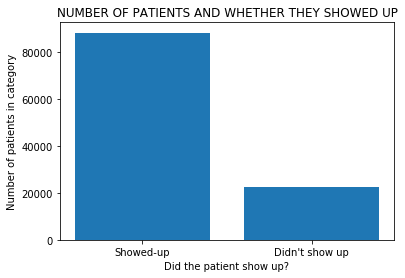

In [29]:
# how many patients showed up for their appointments?

showed_up = df_noshow.query("no_show == 'No'")
didnt_show = df_noshow.query("no_show == 'Yes'")
plt.bar([1,2],[showed_up.shape[0],didnt_show.shape[0]],tick_label=["Showed-up", "Didn't show up"]) ;
plt.xlabel("Did the patient show up?") ;
plt.ylabel("Number of patients in category") ;
plt.title("number of patients and whether they showed up".upper()) ;

The above diagram suggests that most of the patients made their appointments. This means that we'll have to be careful with our comparisons. For example, rather than comparing the number of women who showed up to the number of men who showed up, it's more reasonable to check for a gender bias with respect to whether the patient showed up.

For example, imagine that there were one trillion women and only one-hundred men. Imagine also that half of all women showed up and half of all men showed up. This comparison of proportion tells us that the gender of the patient doesn't bias whether they were likely to show up, because for any given gender the patient is equally likely to have showed up. In other words, nothing about being female would correlate with whether the patient was likely to have showed up. In this imaginary scenario, knowing the patient's gender tells us little about their tendency to have shown up. We may as well flip a fair coin to guess. 

That's the reason why we'll be comparing proportions rather than raw numbers. If we were to compare the raw numbers alone - half of a trillion women against just fifty men, that's like answering a different question entirely - how likely is it that any member of the population is female? This isn't the same thing as determining whether a patient likely showed up, given their gender. What we should do is compare the number of women who showed up to the total number of women. The same goes for men.

In short, what our analysis explores isn't the comparative size of each category, but whether there's any bias in outcome for a given category. The analysis isn't concerned for example with whether there were more women than men, but with whether for a given gender, the patients in that gender category were more or less likely to show up. We'll then compare these likelihoods across categories to draw correlations.

Let's first take a cursory glance through the numerical data for any possible correlations.

In [30]:
# quick statistics

df_noshow.groupby("no_show").mean()

,age,scholarship,sms_received,total_diagnoses,days
no_show,,,,,
No,37.790504,0.093904,0.291337,0.331391,8.754759
Yes,34.316497,0.115538,0.438489,0.283467,15.836105


The above grouped table seems to suggest that people who showed up for appointments ("No" no_show) were usually older (37 years on average) than those who failed to show, were usually not recipients of the scholarship/welfare program, usually didn't receive an sms, were usually diagnosed with more conditions than those who failed to show up, and had fewer days till their appointment.

In contrast, those who couldn't show up were slightly younger (about 34 years of age on average), were usually on the scholarship programme, usually received an sms, usually were diagnosed with fewer conditions, and usually had more days between schedule and appointment.

However, we'll have to address the meaning of the average (i.e. mean) scholarship and sms_received. It's best interpreted loosely in terms of frequency. A mean sms_received is like a mean "YES" or "NO", so let's not interpret it that way. Instead, think of it as the probability of any patient to have received an SMS, given their no_show outcome. Likewise, think of the scholarship the same way.

Before we begin exploring the questions, we'll create two dataframes consisting of patients who showed up for their appointments and those who couldn't show up for their appointments.

In [31]:
# create separate dataframes for the different categories

patients_showed = df_noshow.query("no_show == 'No'")
patients_noshowed = df_noshow.query("no_show == 'Yes'")

total_showed = patients_showed.shape[0] # counts how many rows, which is equivalent to how many people in this class
total_noshowed = patients_noshowed.shape[0]

# a function specific to the df_noshow dataframe
def generate_count(category):
    """category should be column title as a string"""
    return df_noshow.groupby([category,"no_show"]).count()


Let's define a function to count the number of patients for a specific sub-category and no_show outcome.
The variable is represented by the title of the column, and the condition is a specific value we want the variable to take. The showed_up parameter asks whether the patient showed up or not.

In [32]:
# functions that will help in calculating proportions

def catg_count(column, condition):
    """useful for counting the total number of patients in a specific category
    column is the title of column which is string.
    condition is unique value in that column. If condition is string, pass with nested quotes e.g "'tall'".
    """
    return df_noshow.query("{} {} ".format(column,condition)).shape[0] # counts how many rows

def show_count(column, condition, showed_up):
    """useful for counting number of patients who showed or didn't show for a given category.
    column is the title of column which is string.
    condition is unique value in that column. If condition is string, pass with nested quotes e.g "'tall'"
    showed_up is a string - y or n"""
    if showed_up == 'y':
        return patients_showed.query("{}".format(column) + " {}".format(condition)).shape[0] # counts how many rows
    elif showed_up == 'n':
        return patients_noshowed.query("{}".format(column) + " {}".format(condition)).shape[0]


We will be using these functions and values to make our comparisons. For plotting the data, we'll be using grouped bar charts, courtesy of matplotlib.

### Research Question 1 - Is there a correlation between the gender of the patient and whether they showed up for their appointment?

As stated earlier, what we need to compare isn't raw numbers but rather proportions, or probability (from the dataset).
To achieve this, we will group the dataset into four categories - men who showed up, men who didn't show up, women who showed up, women who didn't show up. For each "no_show" category we divide the number of each gender sub-category by the total number of people in that no_show category, e.g. women_who_showed_up / total_showed. This is essentially calculating the probability that a patient showed up, given that they are female.

First, let's inspect the data we need.

In [33]:
# visually inspect the data

gender_count = generate_count("gender")["neighbourhood"] # it doesn't matter the exact column we use
print(gender_count)

gender  no_show
F       No         57245
        Yes        14591
M       No         30962
        Yes         7722
Name: neighbourhood, dtype: int64


The simple table tells us the no_show status by gender. We generated it to get an idea of what to expect. Let's find the total number of women and the total number of men respectively.

In [34]:
# use our function to count the women and men

total_women = catg_count("gender", "=='F'")
total_men = catg_count("gender", "=='M'")

# define this to make calling show_count easier
def g_count(gender,showed_up):
    """gender is gender passed as nested string "'F'" or "'M'"
    showed_up is 'y'/'n'"""
    return show_count("gender","=={}".format(gender),"{}".format(showed_up))

Now, let's count the proportions of women and men for each no_show outcome.

In [35]:
# these represent proportions

women_showed = g_count("'F'",'y') / total_women
women_noshowed = g_count("'F'",'n') / total_women
men_showed = g_count("'M'",'y') / total_men
men_noshowed = g_count("'M'",'n') / total_men

print(women_showed,women_noshowed,men_showed,men_noshowed)

0.7968845704103792 0.2031154295896208 0.8003825871161203 0.19961741288387963


To avoid too much code, we'll have to define several functions. The first returns a duple (array with two values) whose first element is the proportion of patients in that category that showed up, and the last element is the proportion of patients in that category that didn't show up. Referring to this duple will be more convenient than having to create four or more variables every single time. The function's primary purpose is to help us quickly determine the heights of bars in subsequent bar plots.

In [36]:
# define a useful function

def show_duple(column,condition,percent=True):
    """returns np.array duple (proportion who showed, proportion who didn't show) for a given category
    column is name of column as string
    condition is a string. Format as if using .query() function
    percent is to scale proportion to range [0,100]"""
    if percent == True:
        scale = 100
    elif percent == False:
        scale = 1
    total = catg_count(column,condition) # how many people in that catgeory i.e. column-condition e.g. gender-female
    left = scale*(show_count(column,condition,'y') / total) # proportion of category that showed up
    right = scale*(show_count(column,condition,'n') / total) # proportion of category that didn't show up.
    return np.array([left,right])


Now, let's define a function to help us conveniently plot bar graphs using matplotlib. Depending on the dataset, we may have to be careful about how we use the function but it should be straightforward to use most of the time. To give us a bit more room to customise, we'll have to manually call the barplot outside the function.

In [37]:
# for cleaner-looking code, even though it does more than one job

def generate_barplot(which_column, dtype, title, categories, leg_labels):
    """Receives python lists as arguments.
    Use carefully. Args are arrays or strings
    which_column relates to column i.e. variable we want to plot. it's a string, the proper name of the column
    dtype is either string or num. This is important to avoid annoying exceptions
    title is just the title as a string. will be converted to uppercase
    categories is a list of the unique values in the column. Supplied as a parameter for easier customisation.
    leg_labels are to explain what each distinct plot represents (hopefully different colors)
    They're for the legend.
        ["female","male"] or ["scholarship","no scholarship"].
        Do not confuse this with the actual column names.
        """
    ttl = title.upper()
    # notice title is converted to uppercase
    xlab = "Did the patient show up for appointment?"
    ylab = "Proportion of patients"
    xtlab = ["Showed up", "Didn't show up"] # xticks label
    
    
    # this part plots the actual plot
    
    n = leg_labels.shape[0]
    wd = 7/(8*n) # it's assumed that there are as many labels for the legend as there are sub-categories of the column.
    # for example, if column is gender, we expect leg_labels = ["female","male"]. wd just has to be less than 1/n
    x_marks_list = [np.arange(2)+i*wd for i in range(n)] # generates a list of positions for the xticks
    
    # now we need corresponding yvalues. Once again, we assume that the number of sub-categories is specified by leg_labels the legend.
    # it's also assumed that the legend-label is properly ordered
    
    # next step is to generate the appropriate y values for each category. Remember, we need just a pair (duple) for each sub_cat
    sub_cats = []
    if dtype == "num":
        for i in range(categories.shape[0]):
            sub_cats.append(show_duple(which_column,"=={}".format(categories[i]))) # the == condition is an assumption
            # will define another variant of function if needed.
    elif dtype == "string":
        # all that changes is that little bit that's formatted. Don't know any other way to achieve the effect.
        for i in range(categories.shape[0]):
            sub_cats.append(show_duple(which_column,"=='{}'".format(categories[i]))) # the == condition is an assumption
        
    sub_cats = np.array(sub_cats) # an array of each y-value to be plotted.
    # it's assumed that x_marks_list and sub_cats are the same length
    for i in range(n):
        plt.bar(x_marks_list[i],sub_cats[i],width=wd,label=leg_labels[i])
    
    # label the plot
    plt.title(ttl,fontsize=10)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    label_position = 0.5*(x_marks_list[0] + x_marks_list[-1]) # this is an array object. midpoinit of laargest and smallest x_marks
    plt.xticks(label_position, xtlab)
    
    plt.ylim([0,100])
    plt.legend()
    

Now, we can easily plot subsequent bar plots as we desire. Let's begin by visually exploring whether a gender bias exists. If we know a person's gender, how likelier were they to have shown up?

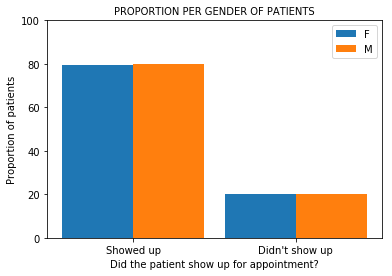

In [38]:
# plot the plots for gender

gender_title = "proportion per gender of patients"
gender_cats = df_noshow["gender"].unique() # an array dtype
gender_labels = df_noshow["gender"].unique() # an array dtype


generate_barplot("gender","string",gender_title, gender_cats, gender_labels)
plt.show()

As expected, the plot correctly shows that more people showed up than didn't show up. But what's important to note visually is that there doesn't seem to be a significant gender bias with respect to whether a patient showed up. Female patients and male patients are nearly equal in proportion for their respective gender, when it comes to whether they showed up. Slightly more male patients showed up than did female patients, but the difference appears to be slight. We can numerically compute the difference using variables we defined earlier...

In [39]:
# print some stats

print(100*(men_showed-women_showed))

0.3498016705741125


### Research Question 2 - Did patients who were on scholarship (welfare) tend to show up more than patients who didn't have the assistance?

Just as we did with gender, we want to explore the proportion of patients on scholarship who showed up, and the proportion of patients on scholarship who didn't show up. The same goes for patients who weren't on the scholarship programme.

In [40]:
# to see what the labels are

df_noshow.scholarship.unique()

array([0, 1])

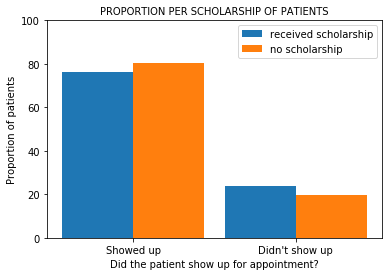

In [41]:
# plot the plots for scholarship

ship_title = "proportion per scholarship of patients"
ship_cats = np.array([1,0])
ship_labels = np.array(["received scholarship", "no scholarship"])

generate_barplot("scholarship","num", ship_title, ship_cats, ship_labels)
plt.show()

The above plot tells us two things. Once again, more people showed up than didn't show up. But apart from this, we have a counter-intuitive result - the patients on scholarship seem to have had a lower tendency to show up, as evidenced by the fact that for the "showed up" group, the left bar is noticeably lower than the right. In other words, if we know that a patient was on the scholarship programme we can conlude that, proportionally, they likely didn't show up compared to those not on the programme. The difference is slight, but it's more noticeable than any gender bias in this dataset.

### Research Question 3 - Did patients who received an SMS notification for their appointment tend to show up more than patients who didn't receive such notifications?

In [42]:
# to see what the labels for sms_received are

df_noshow["sms_received"].unique()

array([0, 1])

[]

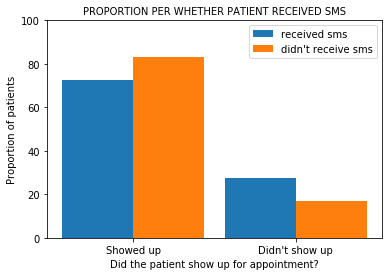

In [43]:
# plot the plots for sms_received

sms_title = "proportion per whether patient received sms"
sms_cats = np.array([1,0])
sms_labels = np.array(["received sms","didn't receive sms"])

generate_barplot("sms_received", "num", sms_title, sms_cats, sms_labels)
plt.plot()

From the bar chart, it's clear that patients who received an sms notification had less likelihood of showing up, which is the same as more likelihood of not showing up. In contrast, patients who didn't receive an sms had a noticeable tendency towards successful appointments. This is somewhat counter-intuitive but perhaps it's a clue that there's a variable influencing this category, that we haven't accounted for.

### Research Question 4 - Did patients who were diagnosed with more conditions tend to show up more than patients who were diagnosed with fewer conditions?

Just as we've done so far, we'll use grouped bar charts to explore this question. There aren't too many total_diagnoses values so it'd be convenient to use grouped bar charts.

In [44]:
# to see the labels for total_diagnoses

df_noshow["total_diagnoses"].unique()

array([1, 0, 2, 3, 4])

We'll have to sort these values for a more cohesive bar plot.

[]

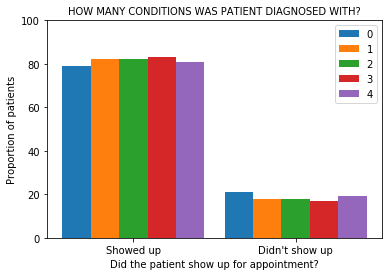

In [45]:
# plot the plot for total_diagnoses

diag_title = "how many conditions was patient diagnosed with?"
diag_cats = np.sort(df_noshow["total_diagnoses"].unique())
diag_labels = np.array(diag_cats[:])

generate_barplot("total_diagnoses", "num", diag_title, diag_cats, diag_labels)
plt.plot()

There are five unique values for the total diagnoses, ranging from 0 through 4. These numbers tell us how many conditions the patient in question was diagnosed with. The conditions are hypertension, diabetes, alcoholism and handicap, but the total_diagnoses variable makes no distinction between these conditions.

Our bar chart shows a slight but noticeable bias in the tendency of patients to have missed their appointments. As the number of diagnoses increased from 0 to 3, the tendency for successful appointments grew proportionally. This means that for patients with fewer than four diagnoses, those with more conditions had a slight tendency to show up compared to those with fewer conditions. Those diagnosed with four conditions had less tendency to show up, but still slightly more than those with 0 conditions.

### Research Question 5 - What is the correlation between the age group of the patients and whether they showed up for their appointments?

To investigate this question, we'll have to group the patients' ages into different quartiles. This is better than calling specific patient ages. Let's write a function which will return an array of quantiles for specific numerical variables. This will be more helpful than directly plotting all 100 or so unique age values side-by-side.

In [46]:
# a function that returns an array of quartiles for a column. (min,25%,median,75%,max)

def get_quarts(column):
    give = [df_noshow["{}".format(column)].quantile(i) for i in np.arange(0,1.1,0.25)]
    return np.array(give)


Let's define a function for quickly getting labels for the quartiles.

In [47]:
# function is specific to this context

def get_quartlabels(quart):
    give = []
    lngth = quart.shape[0]
    # labels half-open intervals [q[i],q[i+1]). Includes minimum, excludes maximum
    for i in range(lngth-1): # max value of i is lngth-2
        val = "{}".format(quart[i]) + "-" + "{}".format(quart[i+1]-1)
        give.append(val)
    # label the maximum q[length(q)]
    give.append("{}".format(quart[lngth-1]))
    # return a python list, which is better suited for labels
    return np.array(give)


In fact, to make plotting the grouped bar charts for the distribution easier, we'll have to define several useful functions. Each subsequent function depends on a previous function, but the end goal is to do all the work automatically.

In [48]:
# useful functions

# if we have the array of quartiles, this counts the number of patients in each percentile class
# min<= value < 25%, 25% <= value < 50%, ..., 75% <= value < 100%, then 100%
def count_quart(quart, column):
    """expects a numpy array as quart
    returns total count of all patients in each percentile class [a,b)U[max]
    """
    arr = []
    lngth = quart.shape[0]
    for i in range(lngth-1): # max value of i is lngth-2
        bounds = (quart[i], quart[i+1])
        how_many = catg_count("{}".format(column), " >= {l} and {c}<{u} ".format(c=column,l=bounds[0],u=bounds[1]))
        arr.append(how_many)
    arr.append(catg_count("{}".format(column), "=={}".format(quart[lngth-1])))
    return np.array(arr)

# this does almost the same thing as count_quart. All it changes is to add an extra condition - did the patient show up?
# this the patient not show up? defining this function explicitly likely makes it clearer what subsequent functions are doing.
def showed_quart(quart, column, showed_up):
    """expects a numpy array as quart
    returns total count of all patients in each percentile class [a,b)U[max] who match the show/noshow condition
    showed_up is y/n string"""
    arr = []
    lngth = quart.shape[0]
    if showed_up == 'y':
        schwarg = "No"
    elif showed_up == 'n':
        schwarg = "Yes"
    for i in range(lngth-1): # max value of i is lngth-2
        bounds = (quart[i], quart[i+1])
        how_many = catg_count("{}".format(column), " >= {l} and {c}<{u} and no_show == '{sh}'".format(c=column,l=bounds[0],u=bounds[1],sh=schwarg))
        arr.append(how_many)
    arr.append(catg_count("{}".format(column), "=={q} and no_show == '{sh}'".format(q=quart[lngth-1],sh=schwarg)))
    return np.array(arr)

# this is a specialised function which returns an array of pairs, each of which is useful for the grouped bar chart
def get_yarrs_to_plot(column,quart):
    """intended for plotting the bar graph. Just give the quartile array"""
    yarr = []
    total = count_quart(quart,column) # count how many total in the percentile group
    if 0 in total:
        temp = []
        for item in total:
            if item == 0:
                temp.append(0.000001) # works for now
            else:
                temp.append(item)
        total = np.array(temp)
    prop_showed = 100*(showed_quart(quart,column,'y') / total)
    prop_noshowed = 100*(showed_quart(quart,column,'n') / total)
    n = quart.shape[0]
    for i in range(n):
        left = prop_showed[i]
        right = prop_noshowed[i]
        yarr.append(np.array([left,right]))
    return np.array(yarr)


Finally, let's define a modified version of the barplot generator we had earlier. This one's usage is specific to the quartile plots we'll be using.

In [49]:
# specific to the quartile plots

def generate_barplotq(which_column, title, quarts, leg_labels):   
    """Receives np arrays as arguments
    Use carefully. Args are arrays or strings
    which_column relates to column i.e. variable we want to plot. it's a string, the proper name of the column
    title is just the title as a string. will be converted to uppercase
    categories is a list of the unique values in the column. Supplied as a parameter for easier customisation.
    leg_labels refers to the quartile labels. a function exists for this. Make sure to sort!
    They're for the legend.
        ["female","male"] or ["scholarship","no scholarship"].
        Do not confuse this with the actual column names.
        """
    
    ttl = title.upper()
    # notice title is converted to uppercase
    xlab = "Did the patient show up for appointment?"
    ylab = "Proportion of patients"
    xtlab = ["Showed up", "Didn't show up"] # xticks label
    
    
    # this part plots the actual plot
    
    n = leg_labels.shape[0]
    wd = 7/(8*n)
    x_marks_list = [np.arange(2)+i*wd for i in range(n)] # generates a list of positions for the xticks
    
    # now we need corresponding yvalues. Once again, we assume that the number of sub-categories is specified by leg_labels the legend.
    # it's also assumed that the legend-label is properly ordered
    
    # next step is to generate the appropriate y values for each category. Remember, we need just a pair (duple) for each sub_cat
    y_vals = get_yarrs_to_plot(which_column, quarts)
    
    # it's assumed that x_marks_list and sub_cats are the same length
    for i in range(n):
        plt.bar(x_marks_list[i],y_vals[i],width=wd,label=leg_labels[i])
    
    # label the plot
    plt.title(ttl,fontsize=10)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    label_position = 0.5*(x_marks_list[0] + x_marks_list[-1]) # this is an array object. midpoinit of laargest and smallest x_marks
    plt.xticks(label_position, xtlab)
    
    plt.ylim([0,100])
    plt.legend()
    

Finally, we can plot the grouped bar chart.

[]

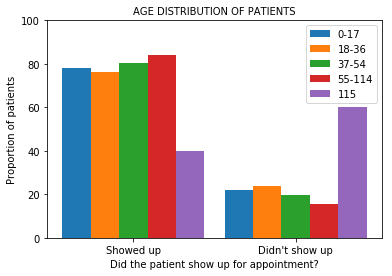

In [50]:
# plot the plot for age

age_title = "age distribution of patients"
age_quarts = get_quarts("age")
age_quarts = np.array(list(map(lambda x:int(x), age_quarts))) # convert to integers
age_labels = get_quartlabels(age_quarts)

generate_barplotq("age",age_title,age_quarts,age_labels)
plt.plot()

There's a roughly linear trend with respect to the age of the patients and their tendency to have shown up. As the grouped bar chart shows, those patients who were older (36 years or more) were likelier to have shown up. The trend is broken by the extreme age groups - the relatively young (0-17) and the rather old (115).

### Research Question 6 - Is there a correlation relating the number of days between schedule and appointment, to whether the patient showed up?

We'll address this question like how we addressed the question of age. We will group the number of days into quartile distributions, then count how many members within each number-of-days distribution then plot the values proportionally.
However, because of the way the data is distributed (the minimum and the 25th percentile are both 0), we'll need to adjust how we label a bit.


[]

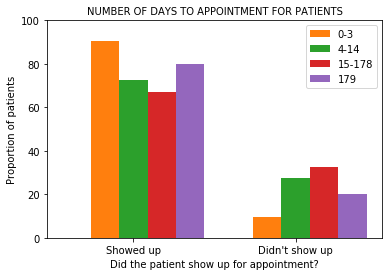

In [51]:
# plot the plot for days

days_title = "number of days to appointment for patients"
days_quarts = get_quarts("days")
days_quarts = np.array(list(map(lambda x:int(x), days_quarts))) # convert to integers
days_labels = [get_quartlabels(days_quarts)[i] for i in range(1,days_quarts.shape[0])] # the first label is not useful.
days_labels = [""] + days_labels # use an empty string for the first label.
days_labels = np.array(days_labels) # convert to array object.

generate_barplotq("days",days_title,days_quarts,days_labels)
plt.plot()

The first column is empty because of the way the data is distributed, and how the quartile-handling functions work. However, this isn't a problem because all of the patients are accounted for, as evidenced by the combined height of the bars for a given colour on both sides.

The trend here is also clear. Patients who had 0-3 days till their appointment had an overwhelming tendency to successfully make their appointments. In contrast, those who had 4-14 days were less likely to show up, and those who had 15-178 days were even less likely to show up. Surprisingly, the few who had exactly 179 days till their appointment were not the least likely to show up, given their category.

This concludes the exploratory stage of our data analysis.

<a id='conclusions'></a>
## Conclusions
In our investigation, we found that the patients who had the most obvious tendency to complete their appointment were...
- Those who had fewer days to appointment (0-3) days
- Those were 37 years or older
- Those diagnosed with one or more conditions

In contrast to that, the following groups of patients had a tendency to miss their appointments:
- Those who had more days to appointment (4 days or more)
- Those who were younger than 37
- Those diagnosed with no conditions

We also found counterintuitively that patients who had scholarship had a noticeable tendency to miss their appointments, as did patients who received an SMS notification about the appointment. In fact, those who weren't on the welfare program/scholarship and who didn't receive an SMS notification had more tendency to show up for their appointments. This suggests that there is perhaps a hidden variable connecting these groups of patients together. There may be some factor we haven't accounted for, which relates to those parameters. I can only guess that it's economic factors at play. If additional research can be done for the average income of each patient, then that could confirm our suspicions.

We found no strong correlation between gender and the likelihood of missing an appointment. There was a slight skew for both genders, but it was fairly small.

<a id='limitations'></a>
## Limitations

As stated previously, we made several assumptions and heuristics when exploring the data.
We ignored the specific nature or subjective severity of each diagnosis when combining all the diagnoses into one column. We did this because we assumed that patients with more diagnoses had a tendency to show up. While the data confirms it, it would still be useful to know which conditions most strongly influenced that tendency.

We also didn't have much information on the exact hour of the appointments. It's possible that such information could have a noticeable effect on the tendency of patients to show up or miss their appointments. For example, out of all those who missed their appointments, what time of the day were their appointments scheduled to hold? Some times of the day are more convenient than others, such as 9AM versus 6AM, or 12PM versus 12AM.

That concludes our investigation.

In [52]:
# to generate html file

from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0